In [1]:
import sys  
sys.path.insert(0, './machine_learning_models')

import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler
from helpers.file import save_file
from joblib import dump
pd.set_option('mode.chained_assignment', None)

In [15]:
first_season = 2012
last_season = 2023

save_models = False

season_file = f'{first_season}-{last_season}'

min_odds = 1.8

first_attr_index = 6
target_index = -3

In [3]:
print('\nGetting data for the model...')

dataset = pd.read_csv('../data/{}.csv'.format(season_file), index_col = 0)
dataset = dataset.loc[(dataset['ODDS_A'].notna()) & (dataset['ODDS_B'].notna())]
dataset['GAME_DATE'] = pd.to_datetime(dataset['GAME_DATE']).dt.date

display(dataset.tail(2))


Getting data for the model...


,SEASON_ID,GAME_DATE,TEAM_A,TEAM_B,ODDS_A,ODDS_B,PTS_A,PTS_CON_A,FG_PCT_A,FG3_PCT_A,...,MATCHUP_B_PCT,HA_B_PCT,STREAK_B,LAST_GAMES_PCT_B,HA_LAST_GAMES_PCT_B,OFF_RTG_B,DEF_RTG_B,WINNER,GAME_PTS_A,GAME_PTS_B
11180,2023,2024-02-08,LAL,DEN,2.28,1.66,123.0,123.266667,0.510733,0.400067,...,0.7,0.538462,2,0.666667,0.6,116.726035,115.160150,A,106,114
11181,2023,2024-02-08,POR,DET,1.11,6.84,107.0,117.333333,0.448333,0.343533,...,0.1,0.130435,1,0.266667,0.4,115.658307,120.879808,A,122,128


In [4]:
# dependent_variables = dataset.iloc[:,first_attr_index:]
# dependent_variables.corr()

In [5]:
def train_predict_model(x_train, y_train, x_test, y_test, season, model):
    model_abbv = model['abbreviation']
    classifier = model['classifier']
    
    classifier.fit(x_train, y_train)
    predictions = classifier.predict(x_test)
    predictions_probabilities = classifier.predict_proba(x_test)
    
    if save_models and season == last_season:
        save_file('../models', classifier, model_abbv)
    
    results_df = pd.DataFrame({
        f"{model_abbv}_PRED": predictions,
        f"{model_abbv}_PROBS_A": predictions_probabilities[:, 1],
        f"{model_abbv}_PROBS_B": predictions_probabilities[:, 0],
    })
    
    return results_df

In [6]:
columns = dataset.columns[first_attr_index:target_index]

save_file('../columns', columns, 'original')

columns_to_drop = ['PER_A', 'PER_B']
columns = [c for c in columns if c not in columns_to_drop]

save_file('../columns', columns, 'filtered')

target_col = dataset.columns[target_index]

print('Columns:', columns)
print('Target:', target_col)

Columns: ['PTS_A', 'PTS_CON_A', 'FG_PCT_A', 'FG3_PCT_A', 'FT_PCT_A', 'REB_A', 'TOV_A', 'SEASON_A_PCT', 'ELO_A', 'MATCHUP_A_PCT', 'HA_A_PCT', 'STREAK_A', 'LAST_GAMES_PCT_A', 'HA_LAST_GAMES_PCT_A', 'OFF_RTG_A', 'DEF_RTG_A', 'PTS_B', 'PTS_CON_B', 'FG_PCT_B', 'FG3_PCT_B', 'FT_PCT_B', 'REB_B', 'TOV_B', 'SEASON_B_PCT', 'ELO_B', 'MATCHUP_B_PCT', 'HA_B_PCT', 'STREAK_B', 'LAST_GAMES_PCT_B', 'HA_LAST_GAMES_PCT_B', 'OFF_RTG_B', 'DEF_RTG_B']
Target: WINNER


In [7]:
main_df = pd.DataFrame()

for season in range(first_season + 1, last_season+1):
    rf_classifier = RandomForestClassifier(n_estimators=500, random_state=0)
    gb_classifier = GradientBoostingClassifier(random_state=0)
    lr_classifier = LogisticRegression()
    svm_classifier = SVC(kernel='rbf', random_state=0, probability=True)
    sgd_classifier = SGDClassifier(loss="log", random_state = 0)

    # Create a voting classifier
    voting_classifier = VotingClassifier(
        estimators=[
            ('LR', lr_classifier),
            ('GB', gb_classifier),
            ('RF', rf_classifier),
        ],
        voting='soft'  # Use 'soft' for probability voting
    )
    
    models = [
        {'classifier': rf_classifier, 'abbreviation': 'RF'},
        {'classifier': RandomForestClassifier(n_estimators=200, random_state=0), 'abbreviation': 'RF_200'},
        {'classifier': RandomForestClassifier(n_estimators=800, random_state=0), 'abbreviation': 'RF_800'},
        {'classifier': gb_classifier, 'abbreviation': 'GB'},
        {'classifier': svm_classifier, 'abbreviation': 'SVM'},
        {'classifier': lr_classifier, 'abbreviation': 'LR'},
        {'classifier': voting_classifier, 'abbreviation': 'VC'},
        {'classifier': GaussianNB(), 'abbreviation': 'NB'},
        {'classifier': KNeighborsClassifier(n_neighbors=500), 'abbreviation': 'KNN'},
        {'classifier': sgd_classifier, 'abbreviation': 'SGD'}, 
    ]

    train_dataset = dataset[dataset['SEASON_ID'] < season]
    x_train = train_dataset[columns]
    y_train = train_dataset[target_col]

    test_dataset = dataset[dataset['SEASON_ID'] == season]
    x_test = test_dataset[columns]
    y_test = test_dataset[target_col]

    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    
    if save_models and season == last_season:
        save_file('../scalers', scaler, 'scaler')
    
    for model in models:
        clear_output(wait=True)
        
        model_abbv = model["abbreviation"]
        print(f"{season}/{last_season} - {model_abbv}")
        
        results_df = train_predict_model(x_train_scaled, y_train, x_test_scaled, y_test, season, model)
        results_df.set_index(test_dataset.index, inplace=True)
        
        test_dataset = pd.merge(test_dataset, results_df, left_index=True, right_index=True)

    if main_df.empty:
        main_df = test_dataset
    else:
        main_df = pd.concat([main_df, test_dataset], ignore_index=True)

2023/2023 - SGD


In [19]:
def create_game_profit_col(row, model_abbv):
    odds = row["ODDS_A" if row[f"{model_abbv}_PRED"] == "H" else "ODDS_B"]
    pred_odds = 1 / (
        row[
            f"{model_abbv}_PROBS_A"
            if row[f"{model_abbv}_PRED"] == "H"
            else f"{model_abbv}_PROBS_B"
        ]
    )
    probs = row[
        f"{model_abbv}_PROBS_A"
        if row[f"{model_abbv}_PRED"] == "H"
        else f"{model_abbv}_PROBS_B"
    ]

    bet_valid = odds >= min_odds and pred_odds < odds

    if bet_valid and row["WINNER"] == row[f"{model_abbv}_PRED"]:
        return odds - 1
    elif bet_valid:
        return -1
    else:
        return 0


display(main_df.head(2))

in_depth_models_for_analysis = ["RF", "RF_500", "GB", "SVM", "LR", "VC", "SGD"]
# in_depth_models_for_analysis = ["VC"]

# Initialize an empty DataFrame to store season-wise statistics
season_stats = pd.DataFrame(columns=["Season"])

for model in models:
    model_abbv = model["abbreviation"]

    main_df[f"{model_abbv}_PROFIT"] = main_df.apply(
        lambda x: create_game_profit_col(x, model_abbv), axis=1
    )
    main_df[f"{model_abbv}_PROFIT_TRACKING"] = main_df[f"{model_abbv}_PROFIT"].cumsum()
    main_df[f"{model_abbv}_STRIKE"] = (
        main_df[f"{model_abbv}_PRED"] == main_df["WINNER"]
    ).astype(int)

    # Calculate Net Gains
    net_gains = main_df[f"{model_abbv}_PROFIT_TRACKING"].iloc[-1]

    # Calculate Yield
    total_profit = main_df[f"{model_abbv}_PROFIT_TRACKING"].iloc[-1]
    total_bets = len(main_df)
    yield_percentage = (total_profit / total_bets) * 100

    # Calculate Strike Rate
    correct_predictions = main_df[f"{model_abbv}_STRIKE"].sum()
    strike_rate_percentage = (correct_predictions / total_bets) * 100

    # Print the results
    print(f"\n{model_abbv} Net Gains: {net_gains}")
    print(f"{model_abbv} Yield: {yield_percentage:.2f}%")
    print(f"{model_abbv} Strike Rate: {strike_rate_percentage:.2f}%")

    if model_abbv not in in_depth_models_for_analysis:
        continue

    # Group by season and calculate overall stats
    model_season_stats = main_df.groupby("SEASON_ID").agg(
        {
            f"{model_abbv}_PROFIT_TRACKING": lambda x: x.iloc[-1] - x.iloc[0],
            f"{model_abbv}_PROFIT": lambda x: (
                x != 0
            ).sum(),  # Counting only non-zero profits as bets
        }
    )

    # Rename columns for clarity
    model_season_stats.columns = [f"{model_abbv}_Net_Gains", f"{model_abbv}_Total_Bets"]

    # Calculate additional statistics
    model_season_stats[f"{model_abbv}_Yield"] = (
        model_season_stats[f"{model_abbv}_Net_Gains"]
        / model_season_stats[f"{model_abbv}_Total_Bets"]
    ) * 100

    # Merge with the overall season_stats DataFrame
    season_stats = pd.merge(
        season_stats,
        model_season_stats,
        left_on="Season",
        right_index=True,
        how="outer",
    )

season_stats.drop("Season", axis=1, inplace=True)

,SEASON_ID,GAME_DATE,TEAM_A,TEAM_B,ODDS_A,ODDS_B,PTS_A,PTS_CON_A,FG_PCT_A,FG3_PCT_A,...,VC_STRIKE,NB_PROFIT,NB_PROFIT_TRACKING,NB_STRIKE,KNN_PROFIT,KNN_PROFIT_TRACKING,KNN_STRIKE,SGD_PROFIT,SGD_PROFIT_TRACKING,SGD_STRIKE
0,2013,2013-11-27,HOU,ATL,1.26,3.96,108.733333,104.266667,0.486933,0.348533,...,1,0.0,0.0,1,0.0,0.0,1,0.0,0.0,1
1,2013,2013-11-27,DAL,GSW,1.52,2.58,105.666667,103.666667,0.473267,0.386933,...,1,0.0,0.0,1,0.0,0.0,1,0.0,0.0,1



RF Net Gains: 150.00999999999954
RF Yield: 1.47%
RF Strike Rate: 65.29%

RF_200 Net Gains: 107.45000000000003
RF_200 Yield: 1.05%
RF_200 Strike Rate: 64.82%

RF_800 Net Gains: 108.73999999999991
RF_800 Yield: 1.07%
RF_800 Strike Rate: 65.15%

GB Net Gains: 113.63999999999994
GB Yield: 1.12%
GB Strike Rate: 64.76%

SVM Net Gains: 59.12999999999992
SVM Yield: 0.58%
SVM Strike Rate: 64.81%

LR Net Gains: 63.609999999999985
LR Yield: 0.62%
LR Strike Rate: 65.32%

VC Net Gains: 138.01999999999975
VC Yield: 1.35%
VC Strike Rate: 65.82%

NB Net Gains: 108.82999999999996
NB Yield: 1.07%
NB Strike Rate: 64.91%

KNN Net Gains: 96.67999999999988
KNN Yield: 0.95%
KNN Strike Rate: 64.91%

SGD Net Gains: -15.869999999999994
SGD Yield: -0.16%
SGD Strike Rate: 63.08%


In [20]:
display(season_stats)

,RF_Net_Gains,RF_Total_Bets,RF_Yield,GB_Net_Gains,GB_Total_Bets,GB_Yield,SVM_Net_Gains,SVM_Total_Bets,SVM_Yield,LR_Net_Gains,LR_Total_Bets,LR_Yield,VC_Net_Gains,VC_Total_Bets,VC_Yield,SGD_Net_Gains,SGD_Total_Bets,SGD_Yield
SEASON_ID,,,,,,,,,,,,,,,,,,
2013,-33.06,214,-15.448598,-32.81,257,-12.766537,-43.82,219,-20.009132,-39.53,219,-18.050228,-26.74,200,-13.370000,-35.60,297,-11.986532
2014,29.31,202,14.509901,25.38,221,11.484163,19.34,183,10.568306,22.92,178,12.876404,36.16,190,19.031579,14.24,211,6.748815
2015,9.68,203,4.768473,13.64,211,6.464455,26.72,208,12.846154,38.86,162,23.987654,39.50,175,22.571429,-22.70,273,-8.315018
2016,40.05,192,20.859375,36.70,223,16.457399,31.90,232,13.750000,17.89,181,9.883978,23.55,188,12.526596,2.28,241,0.946058
2017,31.86,197,16.172589,10.60,208,5.096154,6.26,229,2.733624,9.11,175,5.205714,18.80,181,10.386740,11.75,279,4.211470
2018,21.49,184,11.679348,8.05,214,3.761682,16.42,216,7.601852,6.71,175,3.834286,17.86,177,10.090395,5.63,283,1.989399
2019,29.58,183,16.163934,40.59,194,20.922680,27.65,193,14.326425,13.11,178,7.365169,30.76,183,16.808743,5.06,229,2.209607
2020,-13.88,204,-6.803922,-12.52,209,-5.990431,-11.23,204,-5.504902,-7.65,187,-4.090909,-10.74,191,-5.623037,-16.23,286,-5.674825
2021,10.62,205,5.180488,1.70,195,0.871795,-18.46,217,-8.506912,-2.57,180,-1.427778,-3.54,183,-1.934426,-6.96,198,-3.515152


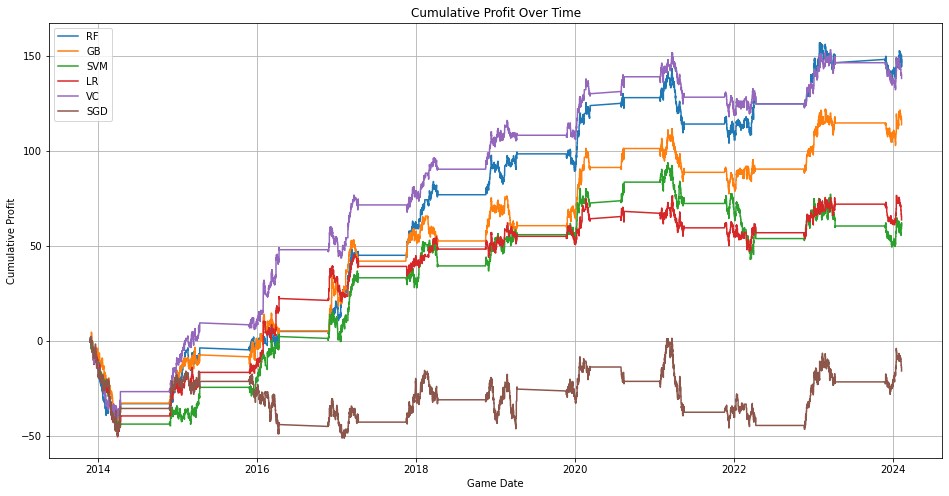

In [21]:
plt.figure(figsize=(16, 8))

for model in models:
    model_abbv = model["abbreviation"]
    if model_abbv in in_depth_models_for_analysis:
        plt.plot(main_df['GAME_DATE'], main_df[f"{model_abbv}_PROFIT_TRACKING"], label = model_abbv)
    
plt.title('Cumulative Profit Over Time')
plt.xlabel('Game Date')
plt.ylabel('Cumulative Profit')
plt.legend()
plt.grid(True)
plt.show()

#### 